# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [379]:
# Import essential libraries for data manipulation and analysis
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [382]:
# Importing the file porter_data_1.csv

porter_df = pd.read_csv('porter_data_1.csv')

# verifying top 5 row
porter_df.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [387]:
# Checking information of data type
porter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 175777 non-null  float64
 1   created_at                175777 non-null  object 
 2   actual_delivery_time      175777 non-null  object 
 3   store_primary_category    175777 non-null  int64  
 4   order_protocol            175777 non-null  float64
 5   total_items               175777 non-null  int64  
 6   subtotal                  175777 non-null  int64  
 7   num_distinct_items        175777 non-null  int64  
 8   min_item_price            175777 non-null  int64  
 9   max_item_price            175777 non-null  int64  
 10  total_onshift_dashers     175777 non-null  float64
 11  total_busy_dashers        175777 non-null  float64
 12  total_outstanding_orders  175777 non-null  float64
 13  distance                  175777 non-null  f

In [389]:
# Checking null value counts
porter_df.isnull().sum()

market_id                   0
created_at                  0
actual_delivery_time        0
store_primary_category      0
order_protocol              0
total_items                 0
subtotal                    0
num_distinct_items          0
min_item_price              0
max_item_price              0
total_onshift_dashers       0
total_busy_dashers          0
total_outstanding_orders    0
distance                    0
dtype: int64

In [391]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

porter_df['created_at'] = pd.to_datetime(porter_df['created_at'])
porter_df['actual_delivery_time'] = pd.to_datetime(porter_df['actual_delivery_time'])

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [394]:
# Convert categorical features to category type

porter_df.market_id = porter_df.market_id.astype('category')
porter_df.order_protocol = porter_df.order_protocol.astype('category')
porter_df.store_primary_category = porter_df.store_primary_category.astype('category')

#convert total_onshift_dashers , total_busy_dashers and total_outstanding_orders to int

porter_df['total_onshift_dashers'] = porter_df['total_onshift_dashers'].astype('int')
porter_df['total_busy_dashers'] = porter_df['total_busy_dashers'].astype('int')
porter_df['total_outstanding_orders'] = porter_df['total_outstanding_orders'].astype('int')


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [398]:
# Calculate time taken in minutes

porter_df['time_taken'] = (porter_df['actual_delivery_time'] - porter_df['created_at'] )/pd.Timedelta(minutes=1)

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [401]:
# Extract the hour and day of week from the 'created_at' timestamp

porter_df['hour'] = porter_df['created_at'].dt.hour.astype('int64')
porter_df['Day'] = porter_df['created_at'].dt.weekday.astype('category')

# Create a categorical feature 'isWeekend'
# 1 weekend ,0 weekdays

porter_df['isWeekend'] = (porter_df['created_at'].dt.dayofweek).apply(lambda x: 0 if x <5  else 1).astype('category')


In [403]:
# Drop unnecessary columns

porter_df.drop(['created_at','actual_delivery_time'],axis=1,inplace=True)

In [405]:
porter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   market_id                 175777 non-null  category
 1   store_primary_category    175777 non-null  category
 2   order_protocol            175777 non-null  category
 3   total_items               175777 non-null  int64   
 4   subtotal                  175777 non-null  int64   
 5   num_distinct_items        175777 non-null  int64   
 6   min_item_price            175777 non-null  int64   
 7   max_item_price            175777 non-null  int64   
 8   total_onshift_dashers     175777 non-null  int64   
 9   total_busy_dashers        175777 non-null  int64   
 10  total_outstanding_orders  175777 non-null  int64   
 11  distance                  175777 non-null  float64 
 12  time_taken                175777 non-null  float64 
 13  hour                      175

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [409]:
# Create copy of actual dataframe this will be used for further analysis.
input_data = porter_df.copy(deep=True)

In [411]:
# Define target variable (y) and features (X)

# Its better to define traget and feature variable post EDA analysis

y = input_data['time_taken'] # Target variable
X = input_data.drop(['time_taken'], axis=1) # Features

In [413]:
print(X.shape)
print(y.shape)

(175777, 15)
(175777,)


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [416]:
# Split data into training and testing sets

#80:20 ratio split with random state
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=42) 

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(140621, 15)
(35156, 15)
(140621,)
(35156,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [420]:
# Define numerical and categorical columns for easy EDA and data manipulation

Numerical_columns =['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 
 'total_busy_dashers' , 'total_outstanding_orders', 'distance', 'hour']


# Categorical columns

Categorical_columns = ['market_id', 'store_primary_category', 'order_protocol', 'Day', 'isWeekend']

print("Numerical column: ", Numerical_columns , '\n')
print("Categorical column: ", Categorical_columns , '\n')


Numerical column:  ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'hour'] 

Categorical column:  ['market_id', 'store_primary_category', 'order_protocol', 'Day', 'isWeekend'] 



##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

In [423]:
# Plot distributions for all numerical columns

plt.figure(figsize=(15, len(Numerical_columns) * 3))

for i, col in enumerate(Numerical_columns, 1):
    plt.subplot(len(Numerical_columns), 4, i)
    sns.histplot(X_train[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

In [425]:
# Distribution of categorical columns


categorical_cols = X_train.select_dtypes(include=['category']).columns

# Set up the plot grid
plt.figure(figsize=(15, len(categorical_cols) * 4))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols), 1, i)
    sns.countplot(data=X_train, x=col, order=X_train[col].value_counts().index, palette='pastel')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

In [427]:
# Distribution of time_taken

plt.figure(figsize=(15, 8))
sns.histplot(y, kde=True, bins=30, color='skyblue')
plt.title('Distribution of Time Taken (minutes)')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

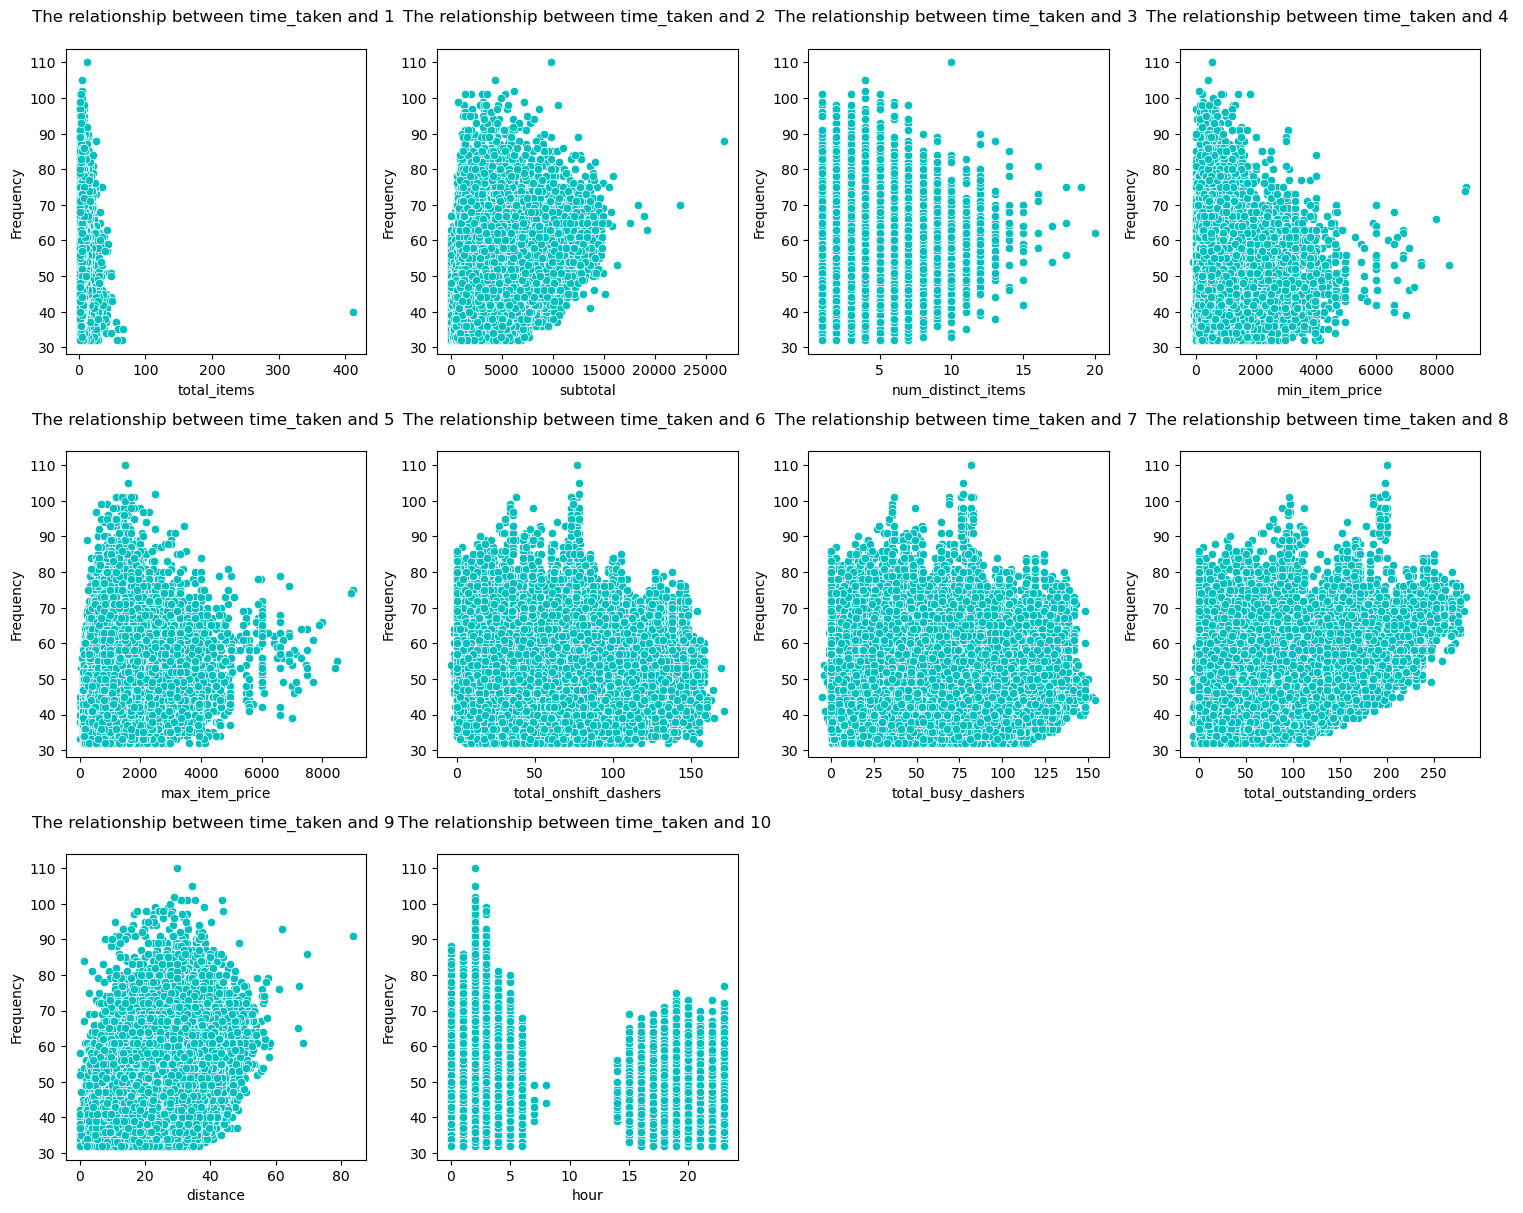

In [430]:
# Scatter plot to visualise the relationship between time_taken and other feature


plt.figure(figsize=(15, 40))

for i, col in enumerate(Numerical_columns, 1):
    plt.subplot(len(Numerical_columns), 4, i)
    sns.scatterplot(x=X_train[col],y=y_train, color='c')
    plt.title(f'The relationship between time_taken and {i} \n')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

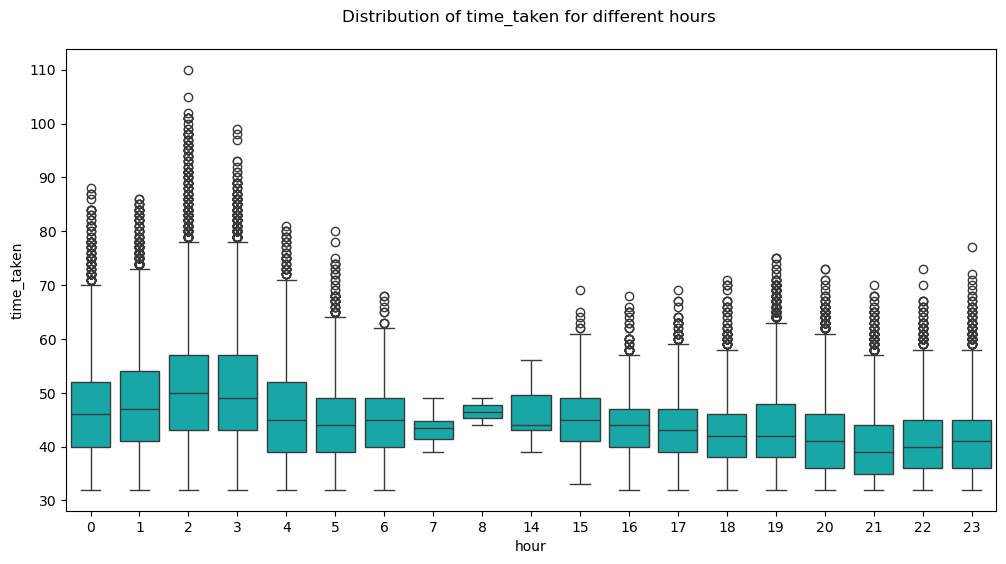

In [431]:
# Show the distribution of time_taken for different hours

plt.figure(figsize=(12,6))

sns.boxplot(x=X_train['hour'],y=y_train,color='c')
plt.title('Distribution of time_taken for different hours \n')
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

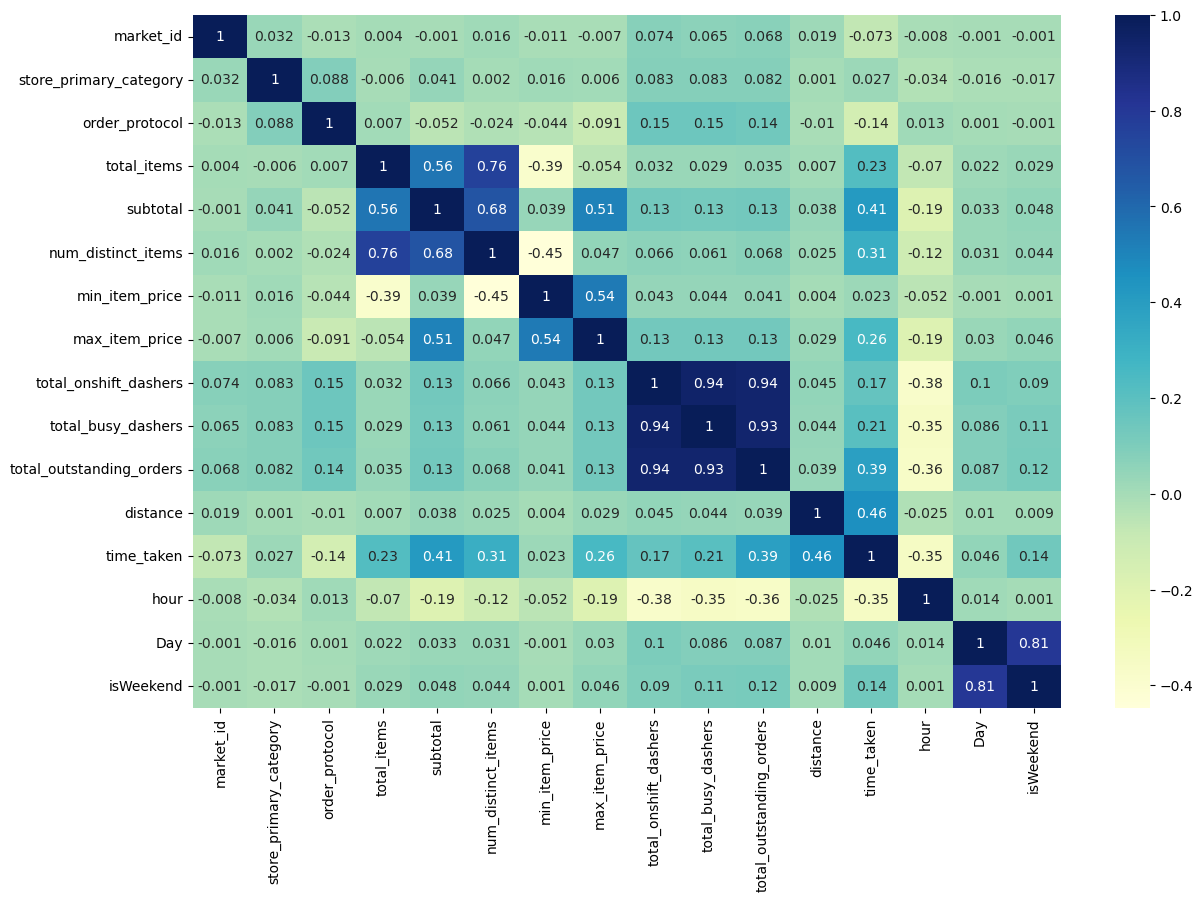

In [435]:
# Plot the heatmap of the correlation matrix

plt.figure(figsize=(14,9))
sns.heatmap(round(porter_df.corr(),3),annot=True,cmap='YlGnBu')
plt.show()

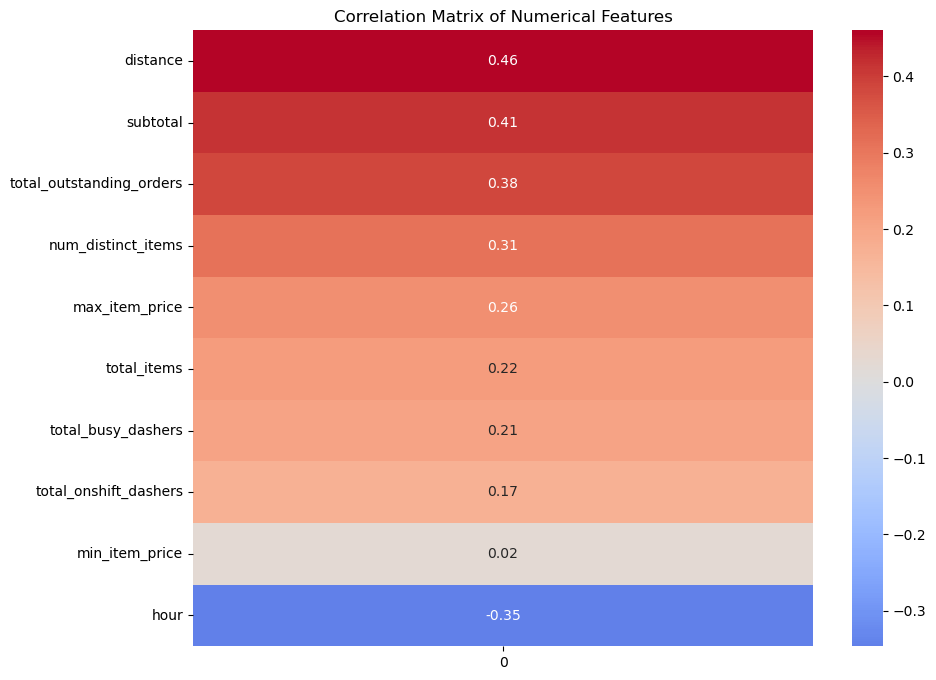

In [436]:

# Display correlation with 'time_taken' only
target_corr = porter_df[Numerical_columns].corrwith(porter_df['time_taken']).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.heatmap(target_corr.to_frame(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [439]:
# Drop 3-5 weakly correlated columns from training dataset

weakly_correlated_columns = ['min_item_price', 'total_onshift_dashers','total_busy_dashers']

X_train.drop(weakly_correlated_columns, axis=1, inplace=True)


In [441]:
# Drop the weakly correlated columns from training dataset

X_test.drop(weakly_correlated_columns, axis=1, inplace=True)

#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

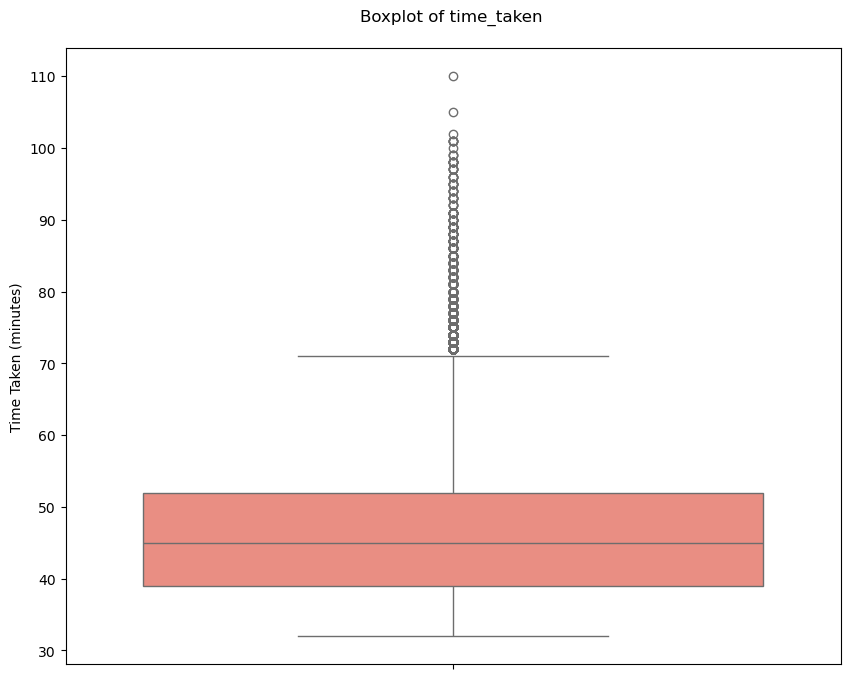

In [444]:
# Boxplot for time_taken
plt.figure(figsize=(10,8))
sns.boxplot(y_train,color='salmon')
plt.title('Boxplot of time_taken \n')
plt.ylabel('Time Taken (minutes)')
plt.show()

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

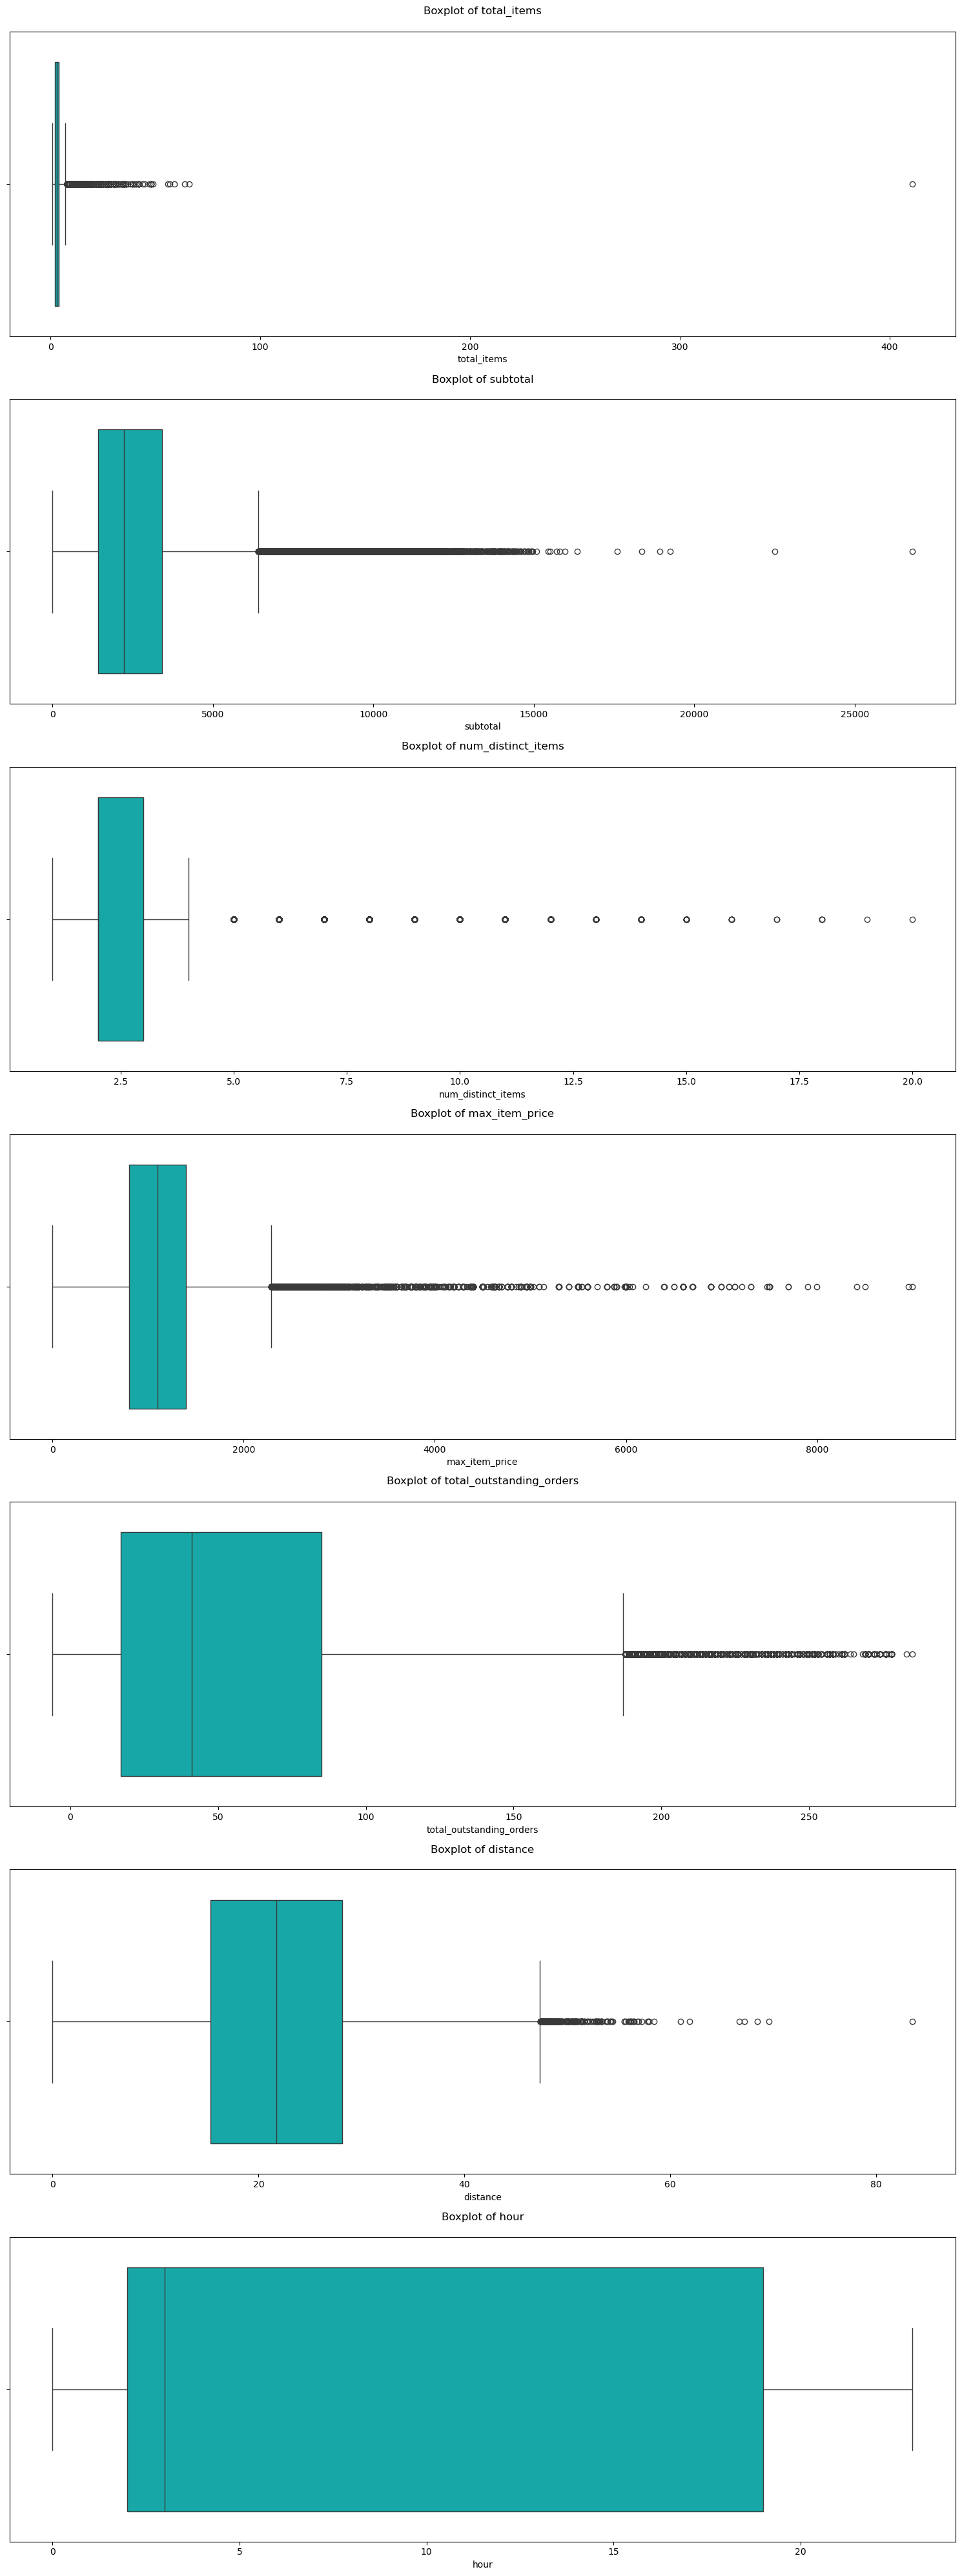

In [449]:
# Handle outliers


numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(15, 40))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, i)
    sns.boxplot(x=X_train[col], color='c')
    plt.title(f'Boxplot of {col}\n')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [453]:
# As per above some column has outlier handling them from train data set

# Define a function to remove outliers using the IQR method
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Remove outliers from all numerical columns
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

X_train = remove_outliers(X_train, numerical_columns)
X_test = remove_outliers(X_test, numerical_columns)

# Verify the changes
print(X_train.shape)

print(X_test.shape)

(120239, 12)
(30022, 12)


In [455]:
# Aligning y_train and y_test with X_train and X_test data set 

y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

In [456]:
# Verifying size of all train and test data set
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(120239, 12)
(30022, 12)
(120239,)
(30022,)


## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [320]:
# Define numerical and categorical columns for easy EDA and data manipulation



#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

In [63]:
# Plot distributions for all numerical columns



##### **4.1.2**
Check the distribution of categorical features

In [65]:
# Distribution of categorical columns



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

In [67]:
# Distribution of time_taken



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

In [69]:
# Scatter plot to visualise the relationship between time_taken and other features



#### **4.3** Drop the columns with weak correlations with the target variable

In [71]:
# Drop the weakly correlated columns from training dataset



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [689]:
X_train_df = X_train.copy(deep=True)
X_test_df = X_test.copy(deep=True)

In [691]:
# Handle categorical columns 
# One-hot encode the categorical columns

X_train_df = pd.get_dummies(X_train_df, columns=['market_id','Day'], drop_first=True,dtype=int)
X_train_df.drop(['store_primary_category','order_protocol'], axis=1, inplace=True)


In [693]:
# Handle categorical columns 
# One-hot encode the categorical columns

X_test_df = pd.get_dummies(X_test_df, columns=['market_id','Day'], drop_first=True,dtype=int)
X_test_df.drop(['store_primary_category','order_protocol'], axis=1, inplace=True)

In [792]:
Numerical_columns.remove('min_item_price')
Numerical_columns.remove('total_onshift_dashers')
Numerical_columns.remove('total_busy_dashers')

In [697]:
print(X_train_df.shape)
print(X_test_df.shape)

(120239, 19)
(30022, 19)


In [699]:
# Import libraries

from sklearn.preprocessing import StandardScaler

#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [704]:
cols = X_train_df.columns

In [706]:
# Apply scaling to the numerical columns

scaler = StandardScaler()
X_train_df = scaler.fit_transform(X_train_df)

X_train_df = pd.DataFrame(X_train_df,columns=cols)
X_train_df.shape

(120239, 19)

In [708]:
# Apply scaling to test dataset as well
X_test_df = scaler.transform(X_test_df)

X_test_df = pd.DataFrame(X_test_df,columns=cols)
X_test_df.head()

total_items  subtotal  num_distinct_items  max_item_price  \
0     0.871634  0.253392            1.299889        0.063872   
1    -1.182308 -0.901172           -1.144460        0.316751   
2     1.556282 -0.578026            1.299889       -1.602599   
3     2.240929  1.149274            0.485106       -0.818675   
4     0.871634  0.669928            0.485106        0.066401   

   total_outstanding_orders  distance      hour  isWeekend  market_id_2.0  \
0                  0.309783  0.760168 -0.789929  -0.697039      -0.648609   
1                 -1.026486 -0.820604 -0.449085  -0.697039      -0.648609   
2                 -1.071028  0.451388  1.482365  -0.697039      -0.648609   
3                 -1.137841 -0.650083  1.141521   1.434641      -0.648609   
4                 -0.291538  0.810864  1.255135   1.434641      -0.648609   

   market_id_3.0  market_id_4.0  market_id_5.0  market_id_6.0     Day_1  \
0      -0.379416       -0.58373      -0.341804      -0.060396 -0.383579   
1      -0.379416       -0.58373       2.925657      -0.060396 -0.383579   
2      -0.379416       -0.58373       2.925657      -0.060396 -0.383579   
3       2.635628       -0.58373      -0.341804      -0.060396 -0.383579   
4      -0.379416       -0.58373      -0.341804      16.557369 -0.383579   

      Day_2     Day_3     Day_4     Day_5     Day_6  
0  2.597952 -0.389605 -0.413433 -0.434838 -0.449316  
1 -0.384919 -0.389605  2.418769 -0.434838 -0.449316  
2  2.597952 -0.389605 -0.413433 -0.434838 -0.449316  
3 -0.384919 -0.389605 -0.413433 -0.434838  2.225603  
4 -0.384919 -0.389605 -0.413433 -0.434838  2.225603

In [728]:
X_train_df.reset_index(drop=True, inplace=True)
X_test_df.reset_index(drop=True, inplace=True)
#y_train.reset_index(drop=True,inplace=True)
#y_test.reset_index(drop=True,inplace=True) 

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [710]:
# Create/Initialise the model

import statsmodels.api as sm

# Add a constant
X_train_lm = sm.add_constant(X_train_df)
X_test_lm = sm.add_constant(X_test_df)


In [712]:
# Train the model using the training data

model = sm.OLS(y_train, X_train_lm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             time_taken   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     8491.
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        00:25:03   Log-Likelihood:            -3.7693e+05
No. Observations:              120239   AIC:                         7.539e+05
Df Residuals:                  120219   BIC:                         7.541e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [716]:
# dropping column Day_6 with highest pvalue > 0.05

X_train_lm.drop('Day_6',axis=1,inplace=True)
X_test_lm.drop('Day_6',axis=1,inplace=True)

In [718]:
# Calculating VIF 

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_lm.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_lm.values,i) for i in range(len(X_train_lm.columns))]
vif_data['VIF'] = round(vif_data['VIF'], 2)
vif_data = vif_data.sort_values(by = "VIF", ascending = False)
vif_data

Feature   VIF
1                total_items  6.19
3         num_distinct_items  4.80
2                   subtotal  3.90
8                  isWeekend  2.91
4             max_item_price  2.34
9              market_id_2.0  2.01
11             market_id_4.0  1.96
17                     Day_4  1.76
5   total_outstanding_orders  1.71
16                     Day_3  1.70
14                     Day_1  1.69
15                     Day_2  1.69
18                     Day_5  1.64
10             market_id_3.0  1.40
12             market_id_5.0  1.34
7                       hour  1.27
13             market_id_6.0  1.01
6                   distance  1.01
0                      const  1.00

In [720]:
# droping Day_6 columns as it has highest VIF >5 

X_train_lm.drop('total_items',axis=1,inplace=True)
X_test_lm.drop('total_items',axis=1,inplace=True)

In [722]:
#  checking Multicollinearity

vif_data1=pd.DataFrame()
vif_data1["Feature"]=X_train_lm.columns

vif_data1["VIF"]=[variance_inflation_factor(X_train_lm.values,i) for i in range(len(X_train_lm.columns))]
vif_data1['VIF'] = round(vif_data1['VIF'], 2)
vif_data1 = vif_data1.sort_values(by = "VIF", ascending = False)
vif_data1

Feature   VIF
1                   subtotal  3.01
7                  isWeekend  2.91
2         num_distinct_items  2.10
8              market_id_2.0  2.01
10             market_id_4.0  1.96
3             max_item_price  1.82
16                     Day_4  1.76
4   total_outstanding_orders  1.71
15                     Day_3  1.70
13                     Day_1  1.69
14                     Day_2  1.69
17                     Day_5  1.64
9              market_id_3.0  1.40
11             market_id_5.0  1.34
6                       hour  1.27
12             market_id_6.0  1.01
5                   distance  1.01
0                      const  1.00

In [724]:
# Bulding model post removing total_items & isWeekend due to high pvalue & VIF 

model2 = sm.OLS(y_train, X_train_lm)
res3=model2.fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             time_taken   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     9489.
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        00:26:52   Log-Likelihood:            -3.7694e+05
No. Observations:              120239   AIC:                         7.539e+05
Df Residuals:                  120221   BIC:                         7.541e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       44.8490      0.016   2795.817      0.000      44.818      44.880
subtotal                     1.4346      0.028     51.518      0.000       1.380       1.489
num_distinct_items           0.6722      0.023     28.934      0.000       0.627       0.718
max_item_price               0.2468      0.022     11.419      0.000       0.204       0.289
total_outstanding_orders     2.9676      0.021    141.304      0.000       2.926       3.009
distance                     4.2043      0.016    261.002      0.000       4.173       4.236
hour                        -1.1409      0.018    -63.209      0.000      -1.176      -1.106
isWeekend                   -0.5919      0.027    -21.624      0.000      -0.646      -0.538
market_id_2.0               -3.9438      0.023   -173.219      0.000      -3.988      -3.899
market_id_3.0               -1.4674      0.019    -77.430      0.000      -1.505      -1.430
market_id_4.0               -2.9892      0.022   -133.076      0.000      -3.033      -2.945
market_id_5.0               -1.2005      0.019    -64.762      0.000      -1.237      -1.164
market_id_6.0               -0.2810      0.016    -17.385      0.000      -0.313      -0.249
Day_1                       -0.9381      0.021    -45.035      0.000      -0.979      -0.897
Day_2                       -1.2458      0.021    -59.731      0.000      -1.287      -1.205
Day_3                       -1.0379      0.021    -49.634      0.000      -1.079      -0.997
Day_4                       -1.2673      0.021    -59.564      0.000      -1.309      -1.226
Day_5                       -0.0757      0.021     -3.689      0.000      -0.116      -0.035
==============================================================================
Omnibus:                     4315.101   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9072.730
Skew:                           0.244   Prob(JB):                         0.00
Kurtosis:                       4.254   Cond. No.                         3.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [742]:
# Make predictions

y_train_pred=res3.predict(X_train_lm)
y_test_pred=res3.predict(X_test_lm)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Train:",round(r2_train,2),
      "Test:",round(r2_test,2))

Train: 0.57 Test: 0.57


In [734]:
# Find results for evaluation metrics

mae = mean_absolute_error(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_train_pred)

print(f"R2 Score: {r2}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

R2 Score: 0.572972878963113
Mean Absolute Error: 4.3124485646270605
Mean Squared Error: 30.936339585625714
Root Mean Squared Error: 5.562044550848699


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [744]:
# Automated Feature Selection (Recursive Feature Elimination)

estimator=LinearRegression()
selector=RFE(estimator,n_features_to_select=10) #8-20
selector=selector.fit(X_train_lm,y_train)


In [746]:
# Filtering selected feature 

selected_features=X_train_lm.columns[selector.support_]
print(selected_features)

Index(['subtotal', 'total_outstanding_orders', 'distance', 'hour',
       'market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0',
       'Day_2', 'Day_4'],
      dtype='object')


In [748]:
# List of feature selected 

list(zip(X_train_lm.columns,selector.support_,selector.ranking_))

[('const', False, 9),
 ('subtotal', True, 1),
 ('num_distinct_items', False, 5),
 ('max_item_price', False, 7),
 ('total_outstanding_orders', True, 1),
 ('distance', True, 1),
 ('hour', True, 1),
 ('isWeekend', False, 4),
 ('market_id_2.0', True, 1),
 ('market_id_3.0', True, 1),
 ('market_id_4.0', True, 1),
 ('market_id_5.0', True, 1),
 ('market_id_6.0', False, 6),
 ('Day_1', False, 3),
 ('Day_2', True, 1),
 ('Day_3', False, 2),
 ('Day_4', True, 1),
 ('Day_5', False, 8)]

In [771]:
# Build the final model with selected number of features

rfe=sm.OLS(y_train,X_train_lm)# Ordinary Least Squares
res1=rfe.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             time_taken   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     9489.
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        00:39:44   Log-Likelihood:            -3.7694e+05
No. Observations:              120239   AIC:                         7.539e+05
Df Residuals:                  120221   BIC:                         7.541e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       44.8490      0.016   2795.817      0.000      44.818      44.880
subtotal                     1.4346      0.028     51.518      0.000       1.380       1.489
num_distinct_items           0.6722      0.023     28.934      0.000       0.627       0.718
max_item_price               0.2468      0.022     11.419      0.000       0.204       0.289
total_outstanding_orders     2.9676      0.021    141.304      0.000       2.926       3.009
distance                     4.2043      0.016    261.002      0.000       4.173       4.236
hour                        -1.1409      0.018    -63.209      0.000      -1.176      -1.106
isWeekend                   -0.5919      0.027    -21.624      0.000      -0.646      -0.538
market_id_2.0               -3.9438      0.023   -173.219      0.000      -3.988      -3.899
market_id_3.0               -1.4674      0.019    -77.430      0.000      -1.505      -1.430
market_id_4.0               -2.9892      0.022   -133.076      0.000      -3.033      -2.945
market_id_5.0               -1.2005      0.019    -64.762      0.000      -1.237      -1.164
market_id_6.0               -0.2810      0.016    -17.385      0.000      -0.313      -0.249
Day_1                       -0.9381      0.021    -45.035      0.000      -0.979      -0.897
Day_2                       -1.2458      0.021    -59.731      0.000      -1.287      -1.205
Day_3                       -1.0379      0.021    -49.634      0.000      -1.079      -0.997
Day_4                       -1.2673      0.021    -59.564      0.000      -1.309      -1.226
Day_5                       -0.0757      0.021     -3.689      0.000      -0.116      -0.035
==============================================================================
Omnibus:                     4315.101   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9072.730
Skew:                           0.244   Prob(JB):                         0.00
Kurtosis:                       4.254   Cond. No.                         3.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [773]:
# checking Multicollinearity

vif_dt=pd.DataFrame()
vif_dt["Feature"]=X_train_lm.columns

vif_dt["VIF"]=[variance_inflation_factor(X_train_lm.values,i) for i in range(len(X_train_lm.columns))]
vif_dt['VIF'] = round(vif_dt['VIF'], 2)
vif_dt = vif_dt.sort_values(by = "VIF", ascending = False)
vif_dt

Feature   VIF
1                   subtotal  3.01
7                  isWeekend  2.91
2         num_distinct_items  2.10
8              market_id_2.0  2.01
10             market_id_4.0  1.96
3             max_item_price  1.82
16                     Day_4  1.76
4   total_outstanding_orders  1.71
15                     Day_3  1.70
13                     Day_1  1.69
14                     Day_2  1.69
17                     Day_5  1.64
9              market_id_3.0  1.40
11             market_id_5.0  1.34
6                       hour  1.27
12             market_id_6.0  1.01
5                   distance  1.01
0                      const  1.00

In [754]:
# Loop through the number of features and test the model

y_train_pred=res1.predict(X_train_lm)
y_test_pred=res1.predict(X_test_lm)

from sklearn.metrics import r2_score
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Train:",round(r2_train,2),"Test:",round(r2_test,2))


Train: 0.57 Test: 0.57


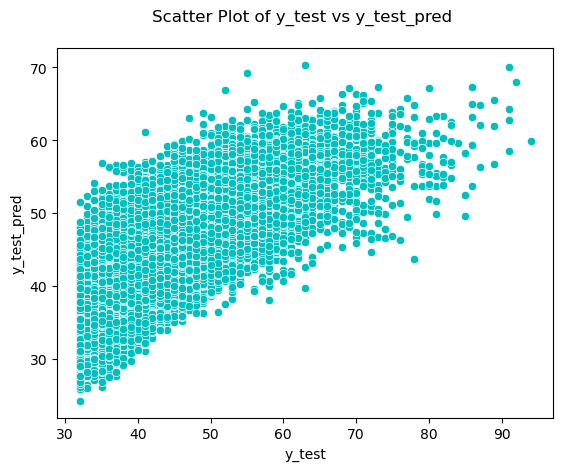

In [760]:
sns.scatterplot(x=y_test, y=y_test_pred,color='c')

plt.title("Scatter Plot of y_test vs y_test_pred \n" )
plt.xlabel("y_test")
plt.ylabel("y_test_pred")
plt.show()

## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

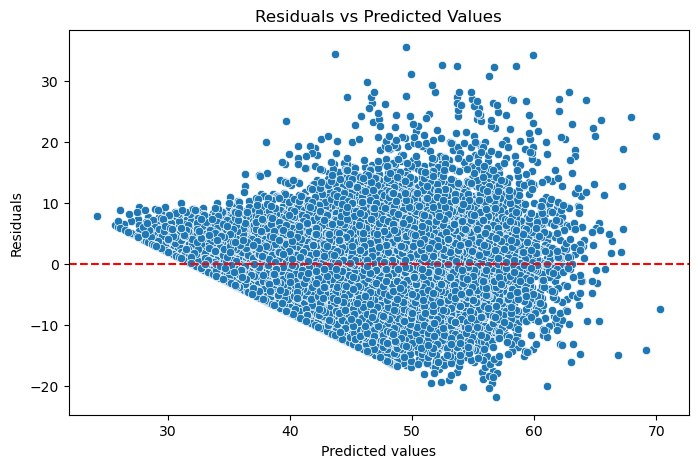

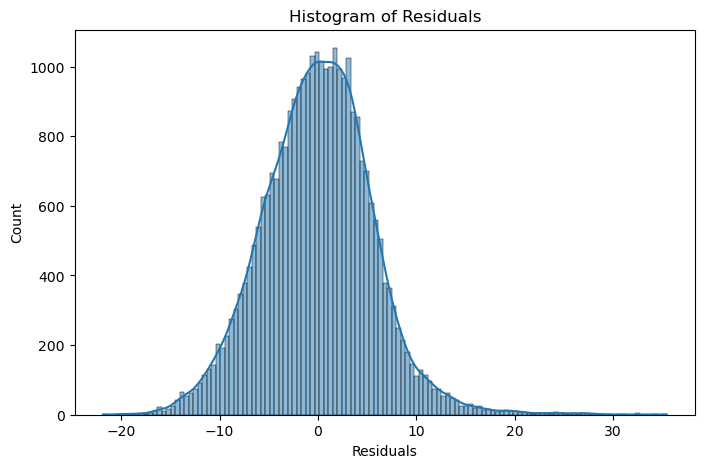

In [762]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

residuals = y_test - y_test_pred

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals")
plt.show()


[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [ ]:
# Compare the scaled vs unscaled features used in the final model



Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [ ]:
# Analyze the effect of a unit change in a feature, say 'total_items'



Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
> Yes, there are categorical variables in the porter dataset such as marketid, store_primary_category, order_protocol, day_of_week, isWeekend.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
> It use to split data into train and test data set here `test_size` = `0.2` means test data and rest 80 % will be train data set. 



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
> `Distance` has highest correlation with target variable `time_taken` with `0.46`, meaning longer distances significantly increase delivery times.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

I have used `IQR` method to detect outliers for each numberical variable. I commputed `Q1` and `Q3` followed by `IQR(Q3-Q1)` and defined lower and upper bound as `Q1 - 1.5(IQR)` and `Q3 + 1.5(IQR)`.
>



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
Below there are the top features with significantly affecting the delivery time

> `total_outstanding_orders` : coefficent -> 2.9676
> 
> `distance` : coefficent -> 4.2043
> 
> `subtotal` : coefficent -> 1.4336 



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>Linear Regression falls under supervised leanring and it used to build relationship between dependent variable `Target` and independent ?variables `Features` by fitting Lineaar equation [y = mX +b].
>

> The Goal of `Linear Regression` is to find **best-fit** line that minimizes the error between predicted and actual values.

> Types of Linear Regression
>1. `Simple Linear Regression` (only one independent variable)
>2. `Multiple Linear Regression` (Many independent variable) 

> Important Assumptions
> `Linearity`: Relationship between variable is linear
> 
> `Independence`: Features are not correlated
> 
> `Homoscedasticity`: Constant error variance
> 
> `No Multicollienearity`: Features should not be highly correlated 




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
> Simple linear regression :
> 1. In simple linear regression we have one Independent variable & one dependent variable.
> 2. y = b + mX
>
>  
>
> Multiple linear regreesion :
> 1. In case of multiple linear regression we have more than 1 independent variable which affecting target variable.
> 2. Y = b0 + b1X1 + b2X2 + b3X3... bnXn



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>
>  Cost or loss function measures how well the model fits the data by calculating difference between predicted and actual valus. One of the most comman industry metric is Mean Squared Error(MSE).

>Cost function can be minimized by using Gradient Desent
> - Calculate slope of cost function 
> - Adjust model parameters 
> - continue updating parameter untile minimum 




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**


> 1. **Underfitting** - Occures when a model fails to capture the pattern in data, this can be caused if model is too simple and does not observe from training data, leading to poor performance on both training and test data.
>    
> 2. **Overfitting** - it occurs when model learns training data too good, including noise. With increased complexity model performs well on training data and poorly on test and unknown data. To simplify models, learn training data instead of learning its patterns.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
> In residual plot, if the residuals are randomly distributed around 0 then the LR model is considered good. So, there should be no visible patterns in residuals.